In [1]:
from utils.binaries import *
from utils.plotting import *

14:59:10 [INFO] utils          -- ( +2752ms) -- import logging
14:59:10 [INFO] utils.binaries -- (  +147ms) -- import numpy as np
14:59:10 [INFO] utils.binaries -- (    +8ms) -- import uncertainties
14:59:11 [INFO] utils.binaries -- (  +226ms) -- import pandas as pd
14:59:11 [INFO] utils.binaries -- (    +1ms) -- import binaries.tools as tools
14:59:11 [INFO] utils.plotting -- (  +417ms) -- import matplotlib.pyplot as plt
14:59:12 [INFO] utils.plotting -- (  +445ms) -- import seaborn as so
14:59:12 [DBUG] utils.plotting -- (    +8ms) -- font size set to 9.5
14:59:12 [DBUG] utils.plotting -- (    +1ms) -- label size set to 13.0
14:59:12 [DBUG] utils.plotting -- (    +1ms) -- figure size set to [6.6, 3.3]
14:59:12 [DBUG] utils.plotting -- (    +0ms) -- markersize set to 2.0
14:59:12 [DBUG] utils.plotting -- (    +1ms) -- usetex set to False
14:59:12 [INFO] utils.plotting -- (    +1ms) -- import plotting.tools as plot


In [2]:
from utils.Auger.SD.UubRandoms import UubRandom

In [3]:
%load_ext scalene

Nuria = UubRandom('NuriaJr', 'wcd')[0]

LOADING
Scalene extension successfully loaded. Note: Scalene currently only
supports CPU+GPU profiling inside Jupyter notebooks. For full Scalene
profiling, use the command line version. To profile in line mode, use
`%scrun [options] statement`. To profile in cell mode, use `%%scalene
[options]` followed by your code.


In [9]:
def filter_and_downsample_old(*traces : np.ndarray, random_phase : int = 1) -> list :

    filtered_and_downsampled_traces = []

    # see Framework/SDetector/UUBDownsampleFilter.h in Offline main branch for more information
    kFirCoefficients = np.array([ 5, 0, 12, 22, 0, -61, -96, 0, 256, 551, 681, 551, 256, 0, -96, -61, 0, 22, 12, 0, 5 ])
    buffer_length = int(0.5 * len(kFirCoefficients))
    kFirNormalizationBitShift = 11
    kADCSaturation = 4095

    clip = lambda x : np.max([0, min([x, kADCSaturation])])

    for pmt in traces:
        temp = np.zeros(len(pmt) + len(kFirCoefficients), dtype=int)
        trace = np.zeros(len(pmt), dtype=int)

        temp[0 : buffer_length] = pmt[:: -1][-buffer_length - 1 : -1]
        temp[-buffer_length - 1: -1] = pmt[:: -1][0 : buffer_length]
        temp[buffer_length : -buffer_length - 1] = pmt

        # perform filtering
        for j, coeff in enumerate(kFirCoefficients):
            trace += [temp[k + j] * coeff for k in range(0, len(pmt), 1)]

        trace = [clip(adc >> kFirNormalizationBitShift) for adc in trace]       # clipping and bitshifting
        trace = trace[random_phase::3]                                          # perform downsampling
        filtered_and_downsampled_traces.append(np.array(trace, dtype='u2'))

    return filtered_and_downsampled_traces

def filter_and_downsample_new(*traces : np.ndarray, random_phase : int = 1) -> list :
    
    filtered_and_downsampled_traces = []

    # see Framework/SDetector/UUBDownsampleFilter.h in Offline main branch for more information
    kFirCoefficients = np.array([ 5, 0, 12, 22, 0, -61, -96, 0, 256, 551, 681, 551, 256, 0, -96, -61, 0, 22, 12, 0, 5 ])
    buffer_length = int(0.5 * len(kFirCoefficients))
    kFirNormalizationBitShift = 11
    kADCSaturation = 4095
    kFirLen = len(kFirCoefficients)

    for pmt in traces:
        temp = np.zeros(len(pmt) + len(kFirCoefficients), dtype=int)
        temp[0 : buffer_length] = pmt[:: -1][-buffer_length - 1 : -1]
        temp[-buffer_length - 1: -1] = pmt[:: -1][0 : buffer_length]
        temp[buffer_length : -buffer_length - 1] = pmt

        temp_shifted = np.array([temp[k:k+len(pmt)] for k in range(kFirLen)])
        outer_product = temp_shifted * kFirCoefficients[:, np.newaxis]

        trace = np.sum(outer_product, axis=0)
        trace = np.clip(np.right_shift(trace, kFirNormalizationBitShift),0, kADCSaturation)

        # trace = [clip(adc >> kFirNormalizationBitShift) for adc in trace]       # clipping and bitshifting
        trace = trace[random_phase::3]                                          # perform downsampling
        filtered_and_downsampled_traces.append(np.array(trace, dtype='u2'))

    return filtered_and_downsampled_traces

In [19]:
%%scalene

n_loops = 100
from time import perf_counter_ns

for fctn in [filter_and_downsample_old, filter_and_downsample_new]:

    start = perf_counter_ns()
    for i, traces in enumerate(Nuria['traces']):

        _ = fctn(*traces)

        old_algorithm = (traces)
        new_algorithm = (traces)

        if i == n_loops: break
    
    duration = perf_counter_ns() - start
    print(f"{fctn}, {n_loops} loops: {(duration / n_loops) * 1e-6:.3f}ms/it avg. ")

<function filter_and_downsample_old at 0x7f285d20c1f0>, 100 loops: 94.368ms/it avg. 
<function filter_and_downsample_new at 0x7f2862b125f0>, 100 loops: 0.645ms/it avg. 


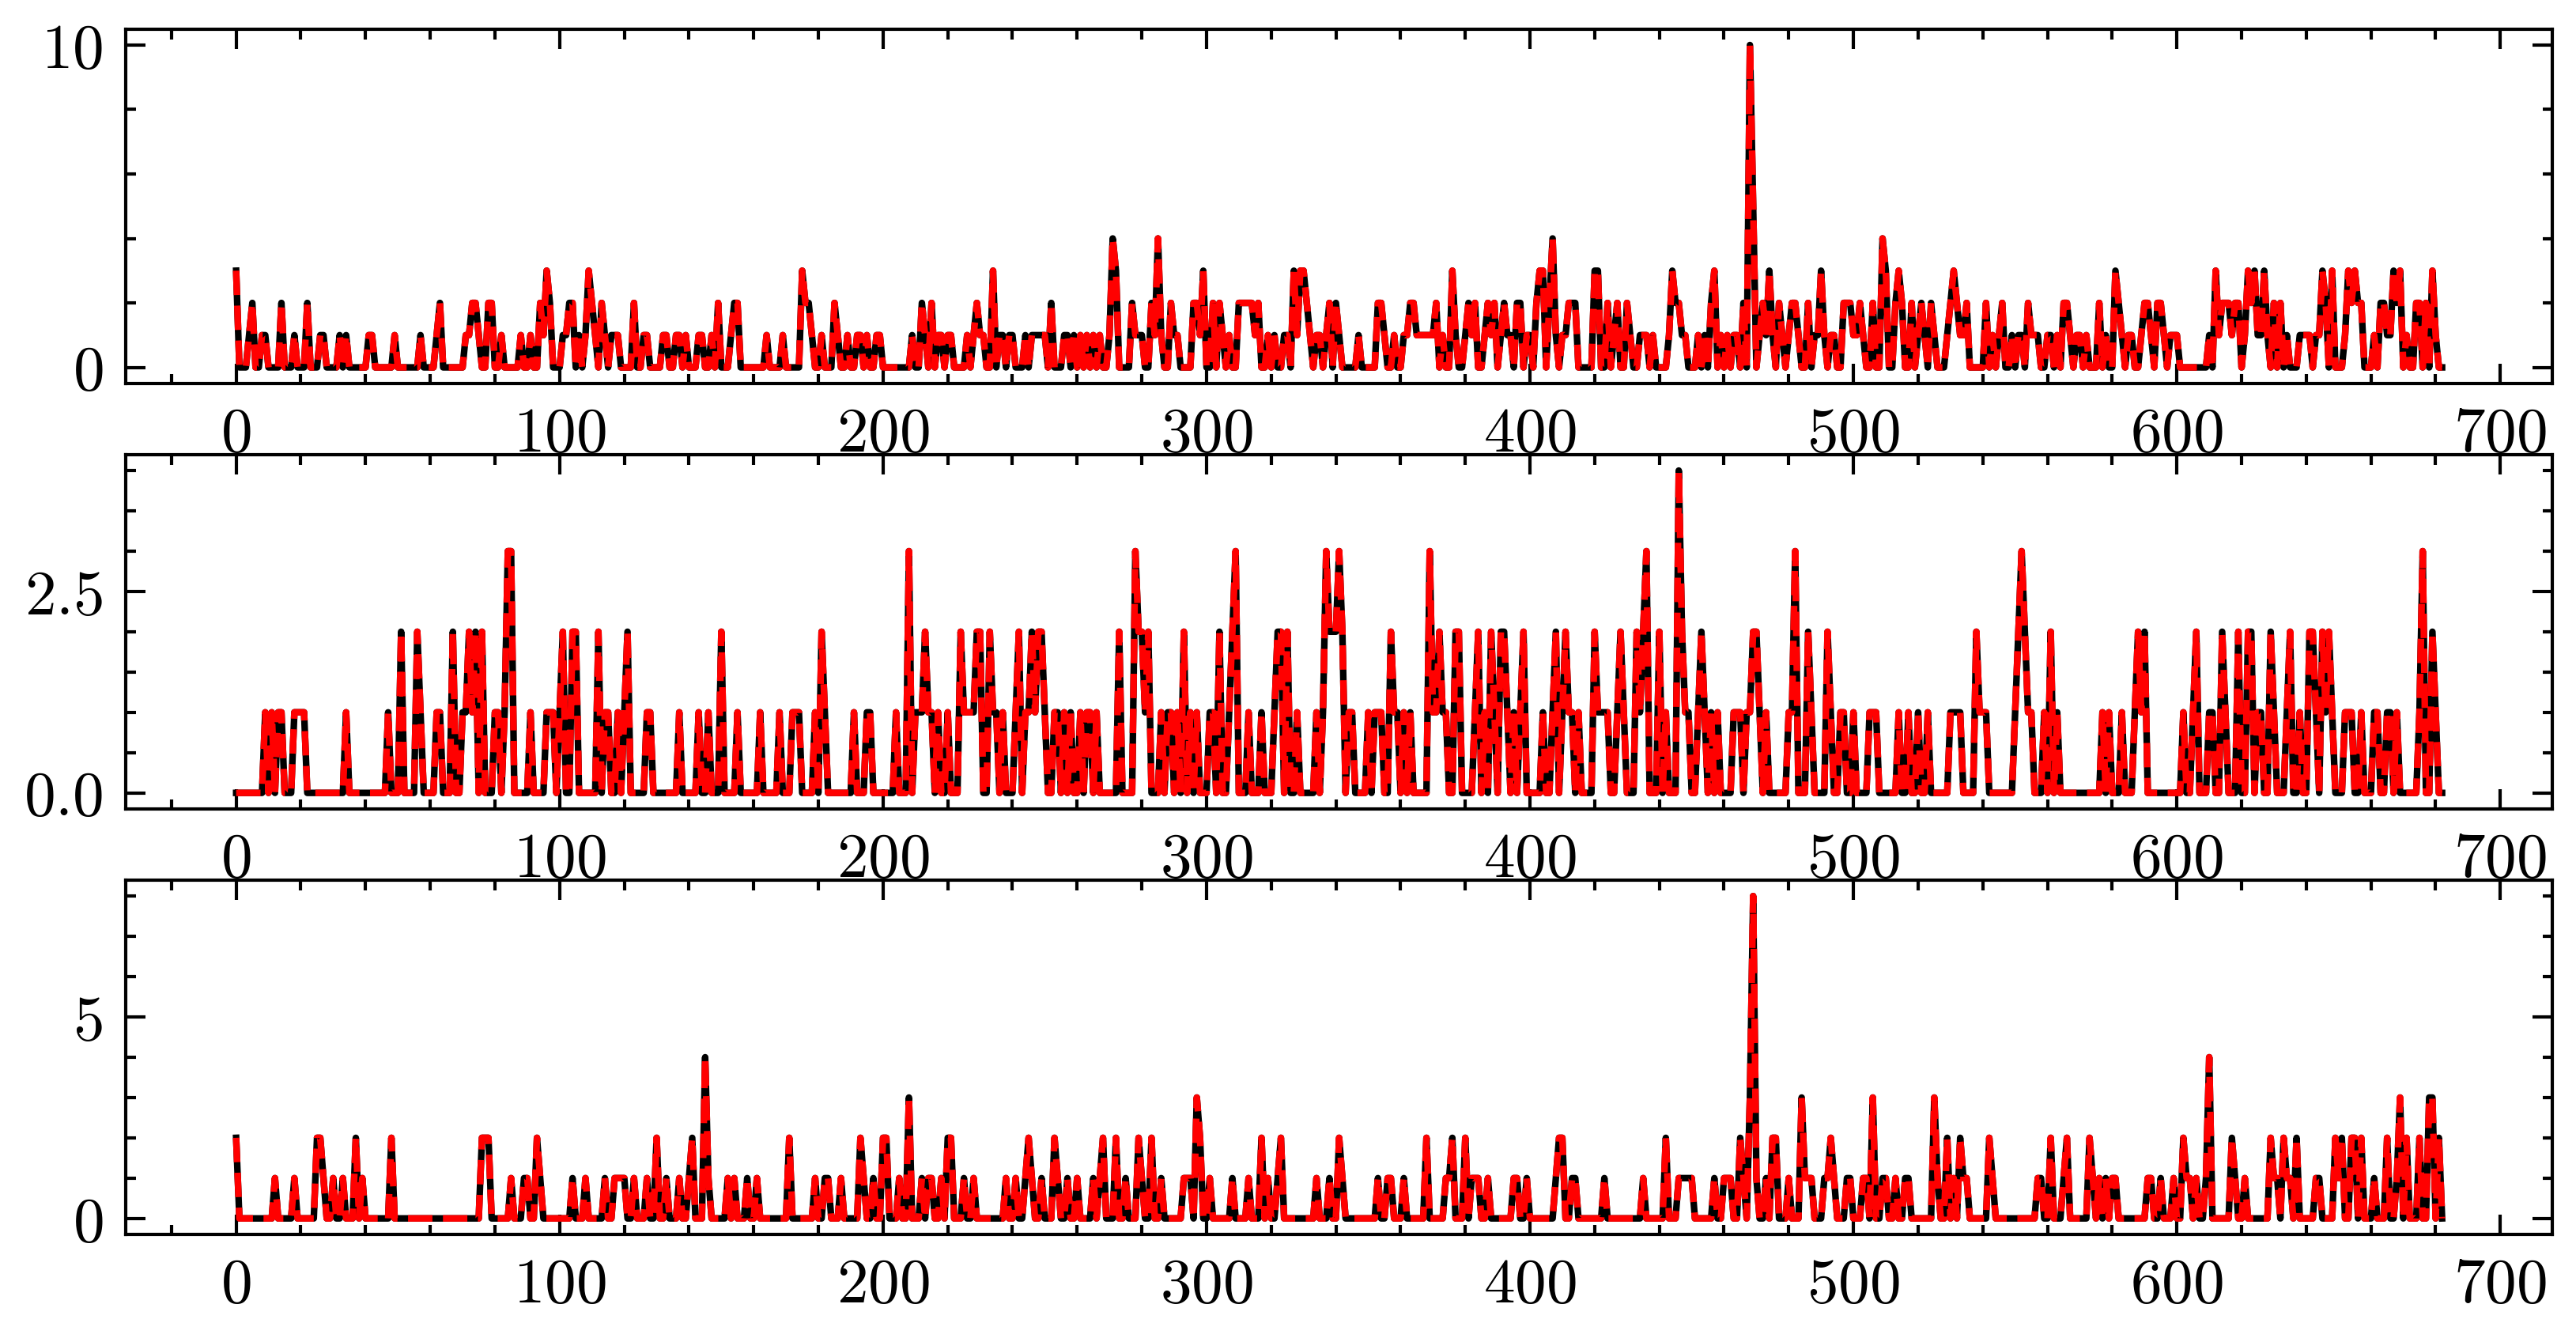

In [11]:

fig, (ax1, ax2, ax3) = plt.subplots(3, 1)
UUB_BINS = 683

ax1.plot(range(UUB_BINS), old_algorithm[0])
ax1.plot(range(UUB_BINS), new_algorithm[0])
ax2.plot(range(UUB_BINS), old_algorithm[1])
ax2.plot(range(UUB_BINS), new_algorithm[1])
ax3.plot(range(UUB_BINS), old_algorithm[2])
ax3.plot(range(UUB_BINS), new_algorithm[2])


In [8]:
%%scalene

traces = Nuria['traces'][0]

random_phase = 1
filtered_and_downsampled_traces = []

# see Framework/SDetector/UUBDownsampleFilter.h in Offline main branch for more information
kFirCoefficients = np.array([ 5, 0, 12, 22, 0, -61, -96, 0, 256, 551, 681, 551, 256, 0, -96, -61, 0, 22, 12, 0, 5 ])
buffer_length = int(0.5 * len(kFirCoefficients))
kFirNormalizationBitShift = 11
kADCSaturation = 4095
kFirLen = len(kFirCoefficients)

clip = lambda x : np.max([0, min([x, kADCSaturation])])

for pmt in traces:
    temp = np.zeros(len(pmt) + len(kFirCoefficients), dtype=int)
    temp[0 : buffer_length] = pmt[:: -1][-buffer_length - 1 : -1]
    temp[-buffer_length - 1: -1] = pmt[:: -1][0 : buffer_length]
    temp[buffer_length : -buffer_length - 1] = pmt

    temp_shifted = np.array([temp[k:k+len(pmt)] for k in range(kFirLen)])
    outer_product = temp_shifted * kFirCoefficients[:, np.newaxis]

    trace = np.sum(outer_product, axis=0)
    trace = np.clip(np.right_shift(trace, kFirNormalizationBitShift),0, kADCSaturation)

    # trace = [clip(adc >> kFirNormalizationBitShift) for adc in trace]       # clipping and bitshifting
    trace = trace[random_phase::3]                                          # perform downsampling
    filtered_and_downsampled_traces.append(np.array(trace, dtype='u2'))

Scalene: The specified code did not run for long enough to profile.
By default, Scalene only profiles code in the file executed and its subdirectories.
To track the time spent in all files, use the `--profile-all` option.
